In [14]:
## read the file (.pairs)

In [222]:
import numpy.random as random
import numpy as np
import math
import networkx as nx
from scipy import sparse as sp
import random
import matplotlib.pyplot as plt

In [313]:
#split and merge for over 3 
def splandmer(group_list,cn) :
    
    num_of_elements = 0 
    while num_of_elements == 2 or num_of_elements == 1 :
        
        group_list.sort()
    
        n_groups = cn 
    
        # set the group 
        set_group = list(set(group_list))
        
        #check the number of elements(not 1 or 2)
        
        for element in set_group :
            if group_list.count(element) == 1 :
                num_of_elements = 1
            elif group_list.count(element) == 2 :
                num_of_elements = 2
    
        # choice for group to be spilit and merge 
        rand_choice = random.choice(set_group)
    
        # get the list of splited and merged group
        gr_change = [y for y in group_list if y == rand_choice]
    
        #get a lenght for selected 
        num_selected = group_list.count(rand_choice)
    
        #print(group_list,rand_choice,num_selected)
        #select number that change elments
        #we should not choose the maximum number of selected group -> it means one group disappear
        change = random.choice([i+1 for i in range(num_selected-1)])
    
        #spliting group 
        split_gr = random.sample(gr_change, change)
    
        #choose group to merge into
        merge_gr = random.choice([z for z in range(cn) if z != rand_choice])
    
        #merging
        cnt = 0
        for idx, val in enumerate(group_list) :
            if val == rand_choice :
                #len(split_gr) = number of elements should be changed
                if cnt <len(split_gr) :
                    group_list[idx] = merge_gr
                    cnt +=1
                else : 
                    break
                
    new_group_list = group_list
      
    return new_group_list
    

In [351]:
def grouping_update(G, group_list, cn) :
    
    result_list = None
    result_Q = None
    move = None
    
    #global move
    sm_group = splandmer(group_list, cn)
    
    #local move
    pat_group = patching(group_list, cn)
    
    # get modularity for global move
    global_Q = get_modularity_nx(G,sm_group)
    
    #get modularity for local move
    local_Q = get_modularity_nx(G, pat_group)
    
    if global_Q >= local_Q :
        result_list = sm_group
        result_Q = global_Q
        move = "g"
    else :
        result_list = pat_group
        result_Q = local_Q
        move = "l"
    
    # result_list is the group for SA
    
    return result_list, result_Q, move

In [315]:
def get_modularity_nx(G, group_list) :
    
    #we need to change here depends on number of groups
    
    comm_0 = [x+1 for x,y in enumerate(group_list) if y == 0]
    comm_1 = [x+1 for x,y in enumerate(group_list) if y == 1]
   
    Q = nx.community.modularity(G,[set(comm_0), set(comm_1)])
    
    return Q

In [276]:
#Wanna get

#a = [0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,1,0,1,0,1,1,1,1,1,1,1,1,1,1,1,1]

#get_modularity_nx(G, a)



[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 17, 18, 20, 22]


0.3569197896120955

In [368]:
#n is number of elements, cn, constrainumber
def initial_grouping(n, cn):

    #get list of nodes
    nodes = [node for node in range(0,n)]
    
    #assign group number to each nodes
    group_assign = [random.randrange(0,cn) for g_num in range(len(nodes))]
    
    return nodes, group_assign

#partition is group-assigned list
def partition_matrix(partition) :
    n = len(partition)
    
    data= np.ones(n)
    #print(data)
    ij = np.array([partition, list(range(0,n))])
    #print(ij)
    grouping_matrix = sp.csr_matrix((data,ij))
    return grouping_matrix

# s = partition matrix, k = degree matrix , m = number of edge 

#generating degree matrix 
def degree_matrix(adj) :
    d_mat = n_A.sum(axis=1)
    return d_mat


def modularity_mat(adj, k, m ):
    
    null_model  = np.dot(k,k.transpose())/(2*m)
    m_m= (adj - null_model)
    
    return m_m

#calculate modularity
def get_modularity(adj, s, k, m):
    
    # formula modularity = (Adj * p_matrix - (d_matrix)^2 * p_matrix/2m) / 2m 
    #adj_partition  = (s* adj *s.transpose()).diagonal().sum()
    #deg_par = np.array(s*k)
    #degree_partition = np.square(deg_par).sum()/(2*m) 
    #modularity
    #Q = (adj_partition - degree_partition) /(2*m)
    
    mod_matrix = modularity_mat(adj, k, m )
    modul = (s*mod_matrix*s.transpose()).diagonal().sum()
    Q = modul/(2*m)
    
    return Q

# this is local movement
def patching(group_list, cn) :
    
    n_nodes =len(group_list)
    #cn is constrained number of groups
    n_groups = cn
    #get index and value that want to change
    
    idx = random.choice([x for x in range(0, n_nodes)])
    val = group_list[idx]
    
    n_val = random.choice([y for y in range(0, n_groups) if y != val])
    
    group_list[idx] = n_val
    patched_group = group_list
    
    return patched_group



def annealing_simulating(G, initial_temp, adj,n, cn,  s, k, m, cooling_constant, iteration) :
    
    svg_group_list = []
    modul_list = []
    old_Q = None
    group_list = None
    movement = {"global":0, "local" :0}
    for i in range(iteration) :
        
        temp = new_temp(cooling_constant, initial_temp, i)
        acceptance = False 
        num_rejection = -1
        #n numberof nodes, cn constrained number of groups
        rej_threshold = cal_rej_thres(n,cn)
        #print(rej_threshold)
        
        while acceptance is False :
            
            num_rejection +=1
            #print(old_Q)
            
            #when the very first
            if old_Q is None :
                node_list , group_list = initial_grouping(n,cn)
                s = partition_matrix(group_list)
                old_Q = get_modularity_nx(G,group_list)
                
            #get new grouping by checking global and local movement
            new_grouping,new_Q,move = grouping_update(G, group_list, cn)
            
            acceptance = check_acceptance(old_Q, new_Q, temp)
            
            #print(acceptance)
            #print(num_rejection)
            if num_rejection > 15000:
                break
            
            
            if acceptance is True :
                
                #if new_grouping in svg_group_list :
                    #acceptance = False
                #else :
                svg_group_list.append(new_grouping)
                modul_list.append(new_Q)
                print(new_grouping)
                print(modul_list[-1])
                old_Q = new_Q
                # accepted grouping would be old grouping and update group based on this grouping 
                group_list = new_grouping
                
                if move == "g" :
                    movement["global"] +=1
                elif move == "l" :
                    movement["local"] +=1
                
    opt = modul_list[-1]
    #idx_opt = modul_list.index(opt)
    
    opt_group = svg_group_list[-1]
    
    opt_grouping = svg_format(opt_group) 
    opt_Q = opt
    
    return opt_grouping, opt_Q, svg_group_list, modul_list, movement
            


# get updated temperature
def new_temp(cooling_constant, prev_temp, times) :
    new_temp = (math.pow(cooling_constant,times)) * prev_temp
    return new_temp 

# check acceptance between old groups and new groups
def check_acceptance(modul_old, modul_new  , temp) :
    if modul_new > modul_old :
        return True
    else :
        new_accept = math.exp((modul_new - modul_old) * temp)
        #modul_new- modul_old is negative value
        # when temp is higher , new_accept is getting smaller 
    return (np.random.random_sample() < new_accept)  #get true or false



#calculate rejection threshold 

def cal_rej_thres(n, nc):
    
    num_pathing = n*nc
    
    num_of_moves = num_pathing
    
    confi = 1 - math.log(0.0000000000000001)/math.log(num_of_moves)
    
    return confi *num_of_moves * math.log(num_of_moves)

#saving format for check group easily 

def svg_format(group_list):
    fin_set ={}
    for idx, gnum in enumerate(group_list):
        if gnum in fin_set :
            fin_set[gnum].append(idx)
        else :
            fin_set[gnum] =[idx]
    return fin_set



In [335]:
cal_rej_thres(34,2)

2792.139105129497

## Simulated Annealing for modularity optimization (Operating code)

## 1)Setup 

In [311]:
G = nx.read_gml('sourcefile/karate.gml', 'id')
n_A = nx.adjacency_matrix(G).toarray()
n = G.number_of_nodes()
m = sum([x[1] for x in G.degree()])
k = degree_matrix(n_A)
cn = 2
#s = partition_matrix(initial_grouping(n,cn)[1])

In [271]:
G

{1: [0, 1, 2, 3, 4, 6, 8, 9, 10, 12, 14, 17, 18, 19, 21, 22, 28, 30, 32], 0: [5, 7, 11, 13, 15, 16, 20, 23, 24, 25, 26, 27, 29, 31, 33]}


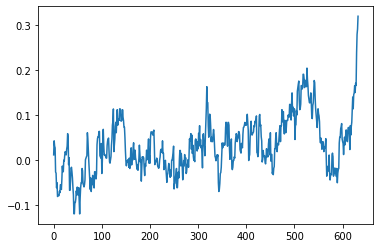

In [338]:
plt.plot(modul_list)
print(opt_grouping)
#a = [0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,1,0,1,0,1,1,1,1,1,1,1,1,1,1,1,1]
#{0:0,1,2,3,4,5,6,7,8,9,10,11,12,13,16,17,19,21
# 1:14,15,18,20,22,23,24,25,26,27,28,29,30,31,32,33}

In [357]:
len(modul_list)
## how can we suggest the number of inner movement 
print(list_opt_grouping)
print(list_opt_Q)

[{1: [0, 1, 2, 3, 6, 7, 10, 13, 14, 15, 17, 22, 25, 27, 29, 31, 32, 33], 0: [4, 5, 8, 9, 11, 12, 16, 18, 19, 20, 21, 23, 24, 26, 28, 30]}]
[0.33793556870479746]


In [364]:
print(list_opt_grouping)
list_opt_Q

[{0: [0, 1, 4, 6, 7, 13, 17, 19, 24, 27, 29, 30, 33], 1: [2, 3, 5, 8, 9, 10, 11, 12, 14, 15, 16, 18, 20, 21, 22, 23, 25, 26, 28, 31, 32]}, {1: [0, 2, 3, 5, 6, 7, 9, 10, 12, 17, 20, 22, 28, 29, 33], 0: [1, 4, 8, 11, 13, 14, 15, 16, 18, 19, 21, 23, 24, 25, 26, 27, 30, 31, 32]}, {0: [0, 2, 4, 5, 6, 7, 8, 10, 11, 12, 13, 14, 15, 17, 18, 23, 24, 28, 29, 30, 32, 33], 1: [1, 3, 9, 16, 19, 20, 21, 22, 25, 26, 27, 31]}, {0: [0, 1, 2, 3, 5, 7, 8, 9, 17, 19, 21, 25, 26, 28, 31, 32], 1: [4, 6, 10, 11, 12, 13, 14, 15, 16, 18, 20, 22, 23, 24, 27, 29, 30, 33]}, {1: [0, 2, 4, 6, 7, 9, 10, 13, 14, 17, 21, 23, 26, 28, 31], 0: [1, 3, 5, 8, 11, 12, 15, 16, 18, 19, 20, 22, 24, 25, 27, 29, 30, 32, 33]}]


[0.31919789612097144,
 0.33127876397107026,
 0.29380341880341815,
 0.3010355029585785,
 0.30761012491781664]

In [366]:
one_Q = []
one_Q.extend(list_opt_Q)
one_grouping = []
one_grouping.extend(list_opt_grouping)

## Operating


In [ ]:
list_opt_grouping = []
list_opt_Q = []
list_modul_list =[]
list_movement = []

for i in range(5) :
    print(str(i) +"try start")
    opt_grouping, opt_Q, saving_group, modul_list, movement = annealing_simulating(G = G, initial_temp = 40, adj = n_A,n =n, cn=2,  s =None, k =k,m= m, cooling_constant = 1.0015, iteration =1200)
    list_opt_grouping.append(opt_grouping)
    list_opt_Q.append(opt_Q)
    list_modul_list.append(modul_list)
    list_movement.append(movement)
    print(str(i) +"try done!")

0try start
[1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1]
-0.026955950032872853
[1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1]
-0.029667981591058306
[1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1]
-0.020052596975673777
[1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1]
-0.0032873109796186365
[1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1]
-0.02375082182774472
[1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1]
-0.0362426035502957
[1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1]
-0.02966798159105828
[1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1]
-0.01060157790

In [ ]:
#n, n_A, m=read_pairs_file("karate.pairs")
n,n_A,m = read_adj_file('sourcefile/karate.adj')
k = degree_matrix(n_A)
#(initial_temp, adj, s, k, m, cooling_constant, iteration)
opt_grouping, opt_Q, saving_group, modul_list = annealing_simulating(initial_temp = 40, adj = n_A,n =n, cn=2,  s =s, k =k,m= m, cooling_constant = 1.0015, iteration =20000) 

In [305]:
opt_grouping
#a = [0,0,0,0,0,0,0,0,1,1,0,0,0,0,1,1,0,0,1,0,1,0,1,1,1,1,1,1,1,1,1,1,1,1]
#{0:0,1,2,3,4,5,6,7,10,11,12,13,16,17,19,21
# 1:8,9,14,15,18,20,22,23,24,25,26,27,28,29,30,31,32,33}

{1: [0, 5, 8, 9, 10, 14, 15, 16, 20, 23, 26, 27, 28, 31, 33],
 0: [1, 2, 3, 4, 6, 7, 11, 12, 13, 17, 18, 19, 21, 22, 24, 25, 29, 30, 32]}

## Simulated Annealing

In [160]:
def annealing_simulating(initial_temp, adj,n, cn,  s, k, m, cooling_constant, iteration) :
    
    svg_group_list = []
    modul_list = []
    old_Q = None
    group_list = None
    for i in range(iteration) :
        
        temp = new_temp(cooling_constant, initial_temp, i)
        acceptance = False 
        num_rejection = -1
        #n numberof nodes, cn constrained number of groups
        rej_threshold = cal_rej_thres(n,cn)
        #print(rej_threshold)
        
        while acceptance is False :
            
            num_rejection +=1
            #print(old_Q)
            
            #when the very first
            if old_Q is None :
                node_list , group_list = initial_grouping(n,cn)
                s = partition_matrix(group_list)
                old_Q = get_modularity(adj, s, k, m)
                
            
            # patching new grouping list
            new_grouping = patching(group_list, cn)
            #print(new_grouping)
            
            # new grouping matrix
            new_s = partition_matrix(new_grouping)
            
            # new modularity with new grouping matrix
            new_Q = get_modularity(adj,new_s,k,m)
            #print(new_Q)
            
            acceptance = check_acceptance(old_Q, new_Q, temp)
            
            #print(acceptance)
            #print(num_rejection)
            if num_rejection > rej_threshold:
                break
            
            
            if acceptance is True :
                
                #if new_grouping in svg_group_list :
                    #acceptance = False
                #else :
                svg_group_list.append(new_grouping)
                modul_list.append(new_Q)
                #print(modul_list[-1])
                old_Q = new_Q
                group_list = new_grouping
                
    opt = max(modul_list)
    idx_opt = modul_list.index(opt)
    
    opt_group = svg_group_list[idx_opt]
    
    opt_grouping = svg_format(opt_group) 
    opt_Q = opt
    
    return opt_grouping, opt_Q, svg_group_list, modul_list
            
        
        

## Getting modularity 

In [183]:
# s = partition matrix, k = degree matrix , m = number of edge 
m = (sumit/2)

def get_modularity(adj, s, k, m ):
    
    # formula modularity = (Adj * p_matrix - (d_matrix)^2 * p_matrix/2m) / 2m 
    
    adj_partition  = (s* adj *s.transpose()).diagonal().sum()
    deg_par = np.array(s*k)
    degree_partition = np.square(deg_par).sum()/(2*m) 
    
    #modularity
    Q = (adj_partition - degree_partition) /(2*m)
    
    return Q
    

78.0


## Degree matrix

In [ ]:
def degree_matrix(adj) :
    d_mat = n_A.sum(axis=1)
    return d_mat

## Initial grouping

In [11]:
#n is number of elements, cn, constrainumber
def initial_grouping(n,cn):
    
    
    #get list of nodes
    nodes = [node for node in range(0,n)]
    
    #assign group number to each nodes
    group_assign = [random.randrange(0,cn) for g_num in range(len(nodes))]
    
    return nodes, group_assign
    

## Getting S(Partition matrix) 

In [15]:
def partition_matrix(partition) :
    print(partition)
    n = len(partition)
    data= np.ones(n)
    print(data)
    ij = np.array([partition, list(range(0,n))])
    print(ij)
    grouping_matrix = sp.csr_matrix((data,ij))
    return grouping_matrix

## Saving format for checking group easily

In [172]:
def svg_format(group_list):
    fin_set ={}
    for idx, gnum in enumerate(group_list):
        if gnum in fin_set :
            fin_set[gnum].append(idx)
        else :
            fin_set[gnum] =[idx]
    return fin_set

## Pathcing the group move singe node into other groups

In [1]:
def patching(group_list, cn) :
    
    n_nodes =len(group_list)
    #cn is constrained number of groups
    n_groups = cn
    #get index and value that want to change
    
    idx = random.choice([x for x in range(0, n_nodes)])
    val = group_list[idx]
    
    n_val = random.choice([y for y in range(0, n_groups) if y != val])
    
    group_list[idx] = n_val
    patched_group = group_list
    
    return patched_group
    